Epoch 1/15
7/7 [==============================] - 5s 526ms/step - loss: 0.6915 - accuracy: 0.6368 - val_loss: 0.6883 - val_accuracy: 0.8519
Epoch 2/15
7/7 [==============================] - 3s 480ms/step - loss: 0.6859 - accuracy: 0.8019 - val_loss: 0.6788 - val_accuracy: 0.7778
Epoch 3/15
7/7 [==============================] - 3s 476ms/step - loss: 0.6744 - accuracy: 0.7783 - val_loss: 0.6580 - val_accuracy: 0.7963
Epoch 4/15
7/7 [==============================] - 3s 472ms/step - loss: 0.6489 - accuracy: 0.8208 - val_loss: 0.6200 - val_accuracy: 0.7593
Epoch 5/15
7/7 [==============================] - 3s 468ms/step - loss: 0.6172 - accuracy: 0.7453 - val_loss: 0.5717 - val_accuracy: 0.7963
Epoch 6/15
7/7 [==============================] - 3s 472ms/step - loss: 0.5726 - accuracy: 0.8208 - val_loss: 0.5299 - val_accuracy: 0.7963
Epoch 7/15
7/7 [==============================] - 3s 470ms/step - loss: 0.5287 - accuracy: 0.8349 - val_loss: 0.4989 - val_accuracy: 0.8148
Epoch 8/15
7/7 [====

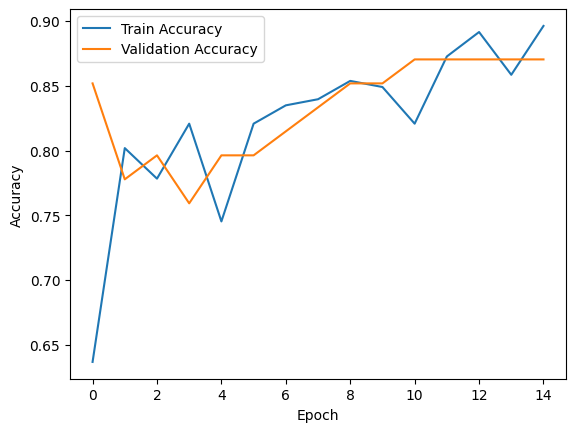

INFO:tensorflow:Assets written to: C:\Users\jk070\AppData\Local\Temp\tmp64nt0ymh\assets


INFO:tensorflow:Assets written to: C:\Users\jk070\AppData\Local\Temp\tmp64nt0ymh\assets


TFLite 모델 변환 및 저장 완료.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt

# 데이터 경로 설정
split_car_folder = "C:\\3-2\\p\\soundDetection\\data\\splitCar"
split_no_car_folder = "C:\\3-2\\p\\soundDetection\\data\\splitNoCar"

# 데이터 준비: Raw Audio
def load_audio_dataset(folder_car, folder_no_car, target_sample_rate=48000, duration=2):
    max_pad_len = target_sample_rate * duration  # 2초 길이의 오디오 (96000 샘플)
    file_paths = []
    labels = []

    # 자동차 소리 데이터
    for file in os.listdir(folder_car):
        if file.endswith('.wav'):
            file_paths.append(os.path.join(folder_car, file))
            labels.append(0)  # 'car'

    # 비자동차 소리 데이터
    for file in os.listdir(folder_no_car):
        if file.endswith('.wav'):
            file_paths.append(os.path.join(folder_no_car, file))
            labels.append(1)  # 'no_car'

    def load_and_pad(file_path):
        # 오디오 읽기
        audio_binary = tf.io.read_file(file_path)
        audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1, desired_samples=max_pad_len)
        audio = tf.squeeze(audio, axis=-1)  # Shape: (max_pad_len,)
        # 패딩 적용
        pad_length = max_pad_len - tf.shape(audio)[0]
        audio = tf.pad(audio, paddings=[[0, pad_length]], mode='CONSTANT')
        return audio

    # 모든 파일을 로드 및 패딩
    audio_data = [load_and_pad(file) for file in file_paths]
    return tf.stack(audio_data).numpy(), np.array(labels)  # Tensor를 NumPy 배열로 변환 후 반환

# 데이터셋 로드
duration = 2  # 2초 길이
target_sample_rate = 48000
X, y = load_audio_dataset(split_car_folder, split_no_car_folder, target_sample_rate, duration)

# 훈련 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TensorFlow Dataset 생성
def create_tf_raw_audio_dataset(X, y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=len(y)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

train_ds = create_tf_raw_audio_dataset(X_train, y_train)
test_ds = create_tf_raw_audio_dataset(X_test, y_test)

# 1D CNN 모델 설계
def create_1d_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(16, kernel_size=9, strides=2, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(32, kernel_size=5, strides=2, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')  # 이진 분류
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 모델 학습
input_shape = (target_sample_rate * duration, 1)  # (96000, 1)
X_train = X_train[..., np.newaxis]  # 채널 차원 추가
X_test = X_test[..., np.newaxis]

train_ds = create_tf_raw_audio_dataset(X_train, y_train)
test_ds = create_tf_raw_audio_dataset(X_test, y_test)

model = create_1d_cnn_model(input_shape)

history = model.fit(train_ds, epochs=15, validation_data=test_ds)

# 테스트 평가
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# 학습 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 모델 저장 (TFLite 변환 용이)
model.save("car_detection_raw_audio_model.h5")

# TensorFlow Lite 모델 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# TFLite 모델 저장
with open("car_detection_raw_audio_model.tflite", "wb") as f:
    f.write(tflite_model)
print("TFLite 모델 변환 및 저장 완료.")
